In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Carboneetal_Pollination.csv")

In [3]:
data.head()

,id,Author,Year,HostPlantSpecies,ResponseVariable,FireFrequency,PostfireTime,FireType,PollinatorGroup,VegetationType,PlantLifeForm,Biome,latitude,longitude,yi,vi
0,1,Adedoja,2022.0,NaN,Visits,Once_burned-unburned,early,Prescribed,Multiple_InsectsOrders,Savana,NaN,Temperate_grasslands._savannas_and_shrublands,29.733333,-83.216667,1.7833,0.9482
1,1,Adedoja,2022.0,NaN,Visits,Once_burned-unburned,early,Prescribed,Multiple_InsectsOrders,Savana,NaN,Temperate_grasslands._savannas_and_shrublands,29.733333,-83.216667,1.9442,0.9817
2,1,Adedoja,2022.0,NaN,Visits,Once_burned-unburned,early,Prescribed,Multiple_InsectsOrders,Savana,NaN,Temperate_grasslands._savannas_and_shrublands,29.733333,-83.216667,1.7973,0.9706
3,2,Arneson,2004.0,Iliamna_bakeri,Visits,NaN,late,Wildfire,Bees,Shrublands,Forbs,Deserts_and_xeric_shrublands,41.658539,-120.498517,-0.1310,0.5024
4,3,Banza,2021.0,NaN,Visits,Once_burned-unburned,early,Wildfire,Bees,Shrublands,NaN,Mediterranean_forests._woodlands_and_scrublands,37.177130,-7.860820,2.1362,1.8711


In [4]:
# Cambio el nombre del data set
pol = pd.DataFrame(data)

Using statsmodels no need to install extra library 

In [5]:
# 1. Metaanálisis de efectos aleatorios (REML)
def random_effects_meta(yi, vi):
    # Pesos para el modelo de efectos aleatorios
    weights = 1 / (vi + np.random.rand() * 1e-10)  # Evitar división por cero
    mean_effect = np.sum(weights * yi) / np.sum(weights)
    
    # Heterogeneidad (tau^2)
    Q = np.sum(weights * (yi - mean_effect)**2)
    df = len(yi) - 1
    C = np.sum(weights) - np.sum(weights**2) / np.sum(weights)
    tau_squared = max(0, (Q - df) / C)
    
    # Pesos actualizados con tau^2
    weights_re = 1 / (vi + tau_squared)
    mean_effect_re = np.sum(weights_re * yi) / np.sum(weights_re)
    variance_re = 1 / np.sum(weights_re)
    
    # Intervalo de confianza
    ci_lower = mean_effect_re - norm.ppf(0.975) * np.sqrt(variance_re)
    ci_upper = mean_effect_re + norm.ppf(0.975) * np.sqrt(variance_re)
    
    return mean_effect_re, variance_re, (ci_lower, ci_upper), tau_squared

mean_effect, variance, ci, tau_squared = random_effects_meta(pol['yi'], pol['vi'])
print("Efecto medio (REML):", mean_effect)
print("Intervalo de confianza (95%):", ci)
print("Tau^2 (heterogeneidad):", tau_squared)

Efecto medio (REML): 0.20875569440552302
Intervalo de confianza (95%): (np.float64(0.03536996397524508), np.float64(0.38214142483580094))
Tau^2 (heterogeneidad): 0.5670307353247729


La estimación del efecto combinado suguiera un efecto positivo del fuego sobre los polinizadores. La heterogeneidad entre los estudios es bastan alta, a tener en cuenta. 

In [6]:
def publication_bias(pol):
    """
    Realiza un análisis de metaanálisis y genera:
    1. Gráfico de embudo (Funnel Plot)
    2. Fail-Safe Number (Rosenberg)
    3. Rank Test (Correlación de Spearman)
    
    Parámetros:
    pol (DataFrame): DataFrame con las columnas 'yi' (tamaños del efecto) y 'vi' (varianzas).
    """
    # Verificar que el DataFrame tiene las columnas necesarias
    if 'yi' not in pol.columns or 'vi' not in pol.columns:
        raise ValueError("El DataFrame debe contener las columnas 'yi' y 'vi'.")
    
    # 1. Metaanálisis de efectos aleatorios (REML)
    def random_effects_meta(yi, vi):
        weights = 1 / (vi + np.random.rand() * 1e-10)  # Evitar división por cero
        mean_effect = np.sum(weights * yi) / np.sum(weights)
        Q = np.sum(weights * (yi - mean_effect)**2)
        df = len(yi) - 1
        C = np.sum(weights) - np.sum(weights**2) / np.sum(weights)
        tau_squared = max(0, (Q - df) / C)
        weights_re = 1 / (vi + tau_squared)
        mean_effect_re = np.sum(weights_re * yi) / np.sum(weights_re)
        variance_re = 1 / np.sum(weights_re)
        return mean_effect_re, variance_re
    
    mean_effect, variance = random_effects_meta(pol['yi'], pol['vi'])
    
    # 2. Gráfico de embudo (Funnel Plot)
    plt.figure(figsize=(8, 6))
    plt.scatter(pol['yi'], 1 / np.sqrt(pol['vi']), color='blue', label='Estudios')
    plt.axvline(x=mean_effect, color='red', linestyle='--', label='Efecto medio')
    plt.xlabel('Tamaño del efecto (yi)')
    plt.ylabel('Precisión (1/SE)')
    plt.title('Funnel Plot')
    plt.legend()
    plt.show()
    
    # 3. Fail-Safe Number (Rosenberg)
    k = len(pol['yi'])  # Número de estudios
    z = mean_effect / np.sqrt(variance)  # Estadístico Z
    fsn = (k * (z**2 - 2.706)) / 2.706
    print(f"Fail-Safe Number (Rosenberg): {fsn:.2f}")
    
    # 4. Rank Test (Correlación de Spearman)
    rank_corr, p_value = spearmanr(pol['yi'], pol['vi'])
    print(f"Rank Test (Spearman correlation): {rank_corr:.2f}, p-value: {p_value:.4f}")

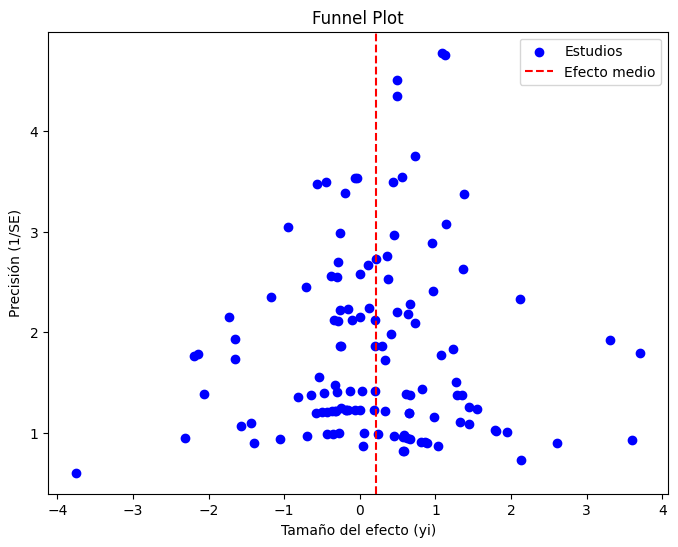

Fail-Safe Number (Rosenberg): 132.23
Rank Test (Spearman correlation): 0.03, p-value: 0.7289


In [9]:
publication_bias(pol)

Un FSN de 132.23 es un valor alto, lo que sugiere que los resultados del metaanálisis son muy robustos y es poco probable que el sesgo de publicación haya influido en los resultados. 
(como regla general si el FSN es mayor que 5k + 10 (donde k es el número de estudios incluidos en el metaanálisis), se considera que los resultados son robustos.) Un coeficiente de Spearman cercano a 0 y un p-value mayor que 0.05 indican que no hay evidencia de sesgo de publicación en el metaanálisis. El p-value obtenido sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de que no hay correlación entre el tamaño del efecto y la varianza.



In [10]:
######## HIERARCHICAL GLOBAL META-ANALYSIS, RANDOM EFFECTS MODEL
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Ajustar un modelo mixto (multinivel)
model = smf.mixedlm("yi ~ 1", pol, groups=pol["id"], vc_formula={"vi": "0 + vi"})
result = model.fit(method="bfgs", reml=True)  # Método REML
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: yi       
No. Observations: 125     Method:             REML     
No. Groups:       40      Scale:              0.5083   
Min. group size:  1       Log-Likelihood:     -170.4487
Max. group size:  12      Converged:          Yes      
Mean group size:  3.1                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.257     0.116  2.214  0.027   0.030   0.484
vi Var     4.417     2.637                              



El intercept (0.257) representa el efecto global del meta-analisis y como el p es menor a 0.05 podemos decir que es significativo, es decir hay un efecto global distinto de cero.   

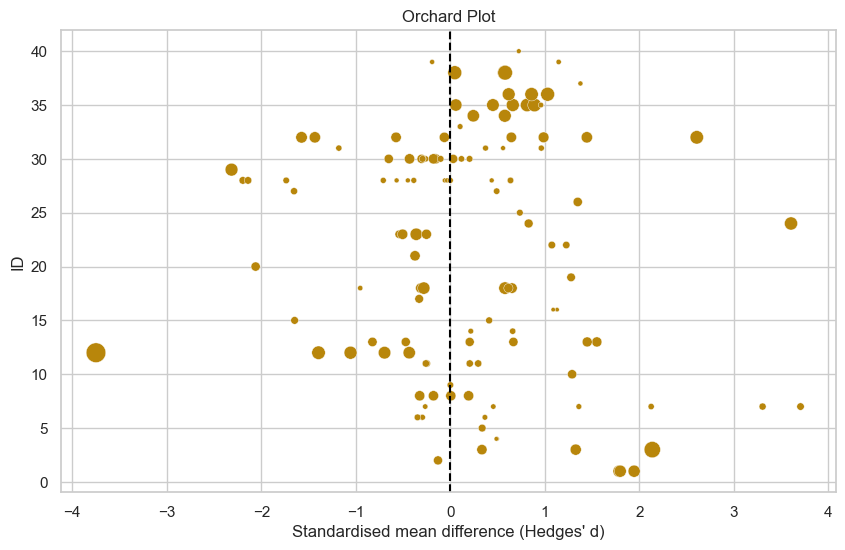

In [43]:
# Crear un gráfico similar a orchard_plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='yi', y='id', data=pol, color='darkgoldenrod', size='vi', sizes=(10, 200), legend=False)
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("Standardised mean difference (Hedges' d)")
plt.ylabel("ID")
plt.title("Orchard Plot")
plt.show()

Este grafico es similar al de orchard_plot de R. 

In [11]:
import seaborn as sns
from scipy.stats import shapiro, probplot

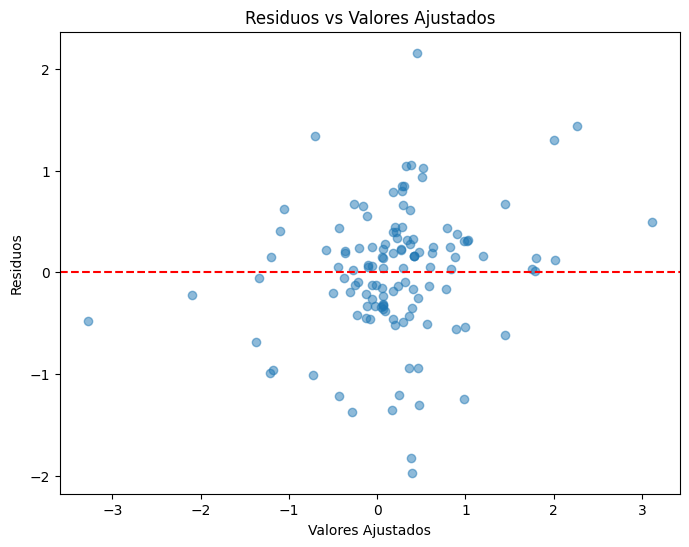

In [12]:
# veficar la normalidad de los residuos
# 1. Obtengo los residuos del modelo
residuos = result.resid
# 2. Gráfico de los residuos vs valores ajustados (para homocedasticidad y linealidad)
fitted_values = result.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores Ajustados")
plt.show()

Se ve bastante bien, estan un poco concentrados hacia el centro pero no se va una forma de embudo o algun patrón particular. 

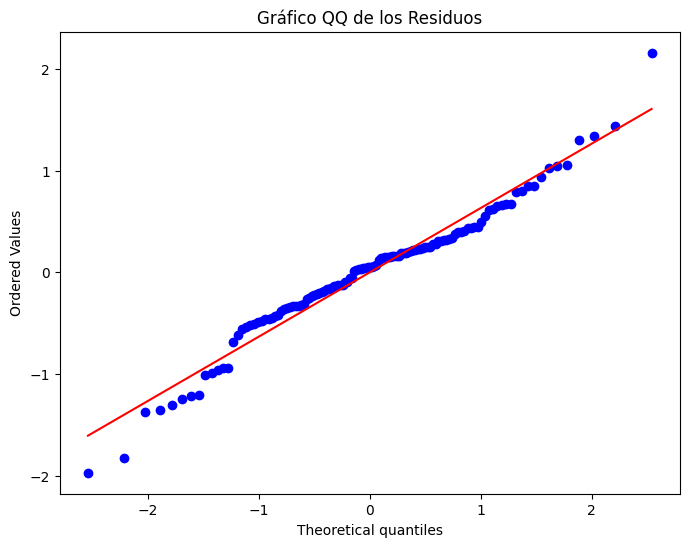

Prueba de Shapiro-Wilk: Estadístico = 0.9703481134700778, p-value = 0.007513180717340027


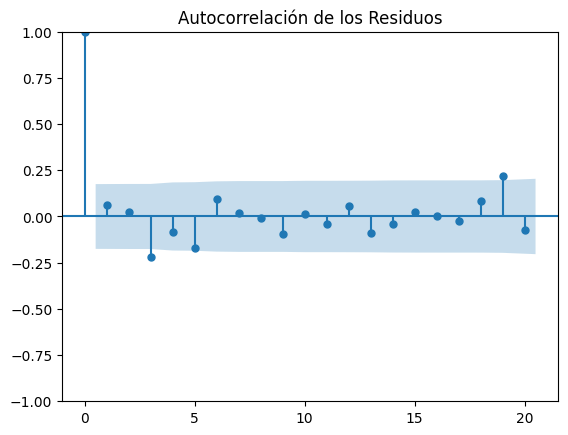

In [13]:
# 3. Gráfico QQ (para normalidad de los residuos)
plt.figure(figsize=(8, 6))
probplot(residuos, dist="norm", plot=plt)
plt.title("Gráfico QQ de los Residuos")
plt.show()

# 4. Prueba de Shapiro-Wilk (para normalidad)
shapiro_test = shapiro(residuos)
print(f"Prueba de Shapiro-Wilk: Estadístico = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

# 5. Gráfico de autocorrelación (para independencia de los residuos)
sm.graphics.tsa.plot_acf(residuos, lags=20)
plt.title("Autocorrelación de los Residuos")
plt.show()

Segun el gráfico Q-Q (Quantile-Quantile plot) los residuos parecen seguir cierta normalidad (hay algunas desviaciones hacia los extremos). Sin embargo en el test de Shapiro el p valor es menor a 0.05 por lo que se rechaza la hipotesis nula de normalidad. Es decir, los residuos no siguen una distribucion normal segun este test. Como en los graficos de diagnostico parece haber normalidad y al no ser extrictamente necestaria en modelos mixtos con un n grande vamos a continuar con el analisis. Además parece no haber autocorrelacion fuerte entre los residuos. 

In [ ]:
# Definir el modelo con ResponseVariable como moderador y efectos aleatorios por "id"
meta_pol2 = smf.mixedlm("yi ~ ResponseVariable",  
                        data=pol,  
                        groups=pol["id"],  # Efectos aleatorios por estudio
                        re_formula="~1")  # Intercepto aleatorio
result = meta_pol2.fit(reml= True)  # REML para máxima verosimilitud restringida

print(result.summary())  # Ver resultados

                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         yi       
No. Observations:           125             Method:                     REML     
No. Groups:                 40              Scale:                      0.7436   
Min. group size:            1               Log-Likelihood:             -178.3207
Max. group size:            12              Converged:                  Yes      
Mean group size:            3.1                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.279    0.725  0.385 0.700 -1.141  1.699
ResponseVariable[T.Pollinated_flowers] -0.828    0.822 -1.007 0.314 -2.439  0.783
ResponseVariable[T.Visits]            

In [ ]:
# Ajustar modelo sin moderadores
meta_pol1 = smf.mixedlm("yi ~ 1", data=pol, groups=pol["id"], re_formula="~1").fit()

# Comparar log-likelihoods de ambos modelos
lr_test = 2 * (result.llf - meta_pol1.llf)  # Test de razón de verosimilitud
p_value = stats.chi2.sf(lr_test, df=1)  # Grados de libertad = 1

print(f"Test de razón de verosimilitud: {lr_test:.3f}, p-value: {p_value:.3f}")


Test de razón de verosimilitud: 6.678, p-value: 0.010


La variable modeladora ResponseVariable mejora significativamente el modelo 